Cleaning the dataset is the first part of the Tardis project. 
We have to select which values are mandatory, which must be corrected and which must be ignored.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The clean_average function handles the average column. It returns a new dataframe with the column specified according to the following rules
    - N/A or <null> value -> 0.0
    - Values formated to HOUR/MIN/SEC (as a string)

In [2]:
def clean_average(column, dataframe):
    df = dataframe.copy()

    # possibly add verif for aberrant values
    df[column] = df[column].fillna(0.0)
    total_seconds = (df[column] * 60).astype(int)
    hours = total_seconds // 3600
    minutes = (total_seconds % 3600) // 60
    seconds = total_seconds % 60
    df[column] = (
        hours.astype(str) + "." + minutes.astype(str) + "." + seconds.astype(str)
    )
    return df


def hms_to_minutes(hms):
    if pd.isna(hms):
        return None
    parts = str(hms).split(".")
    if len(parts) == 3:
        hours, minutes, seconds = map(int, parts)
        return hours * 60 + minutes + seconds / 60
    else:
        return None


def remove_extreme(col, df):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    valid_values_mean = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)][
        col
    ].mean()
    df[col] = df[col].apply(
        lambda x: valid_values_mean if x < lower_bound or x > upper_bound else x
    )

The clean_Pct function handles the Pct column. It returns a new dataframe with the column specified according to the following rules
    - Pct > 100 -> <null>
    - round values to 2 digits

In [3]:
def clean_Pct(column, dataframe):
    df = dataframe.copy()

    df[column] = df[column].where(df[column] < 100.0, np.nan)
    df[column] = df[column].round(2)
    return df

The handle_column_with_train_number handles the columns that contain a number of train. It returns a new dataframe with the column specified according to the following rules:
    - replace non numeric values or float values to null
    - check if the values is < to the number of train at departure (because it is not possible to have more delayed trains then trains at departure)

In [4]:
def handle_column_with_train_number(column, dataframe):
    df = dataframe.copy()

    df[column] = df[column].replace(["N/A", ""], np.nan)
    scheduled = pd.to_numeric(
        df["Number of scheduled trains"].replace(["N/A", ""], np.nan), errors="coerce"
    )
    df[column] = df[column].where(df[column] <= scheduled, np.nan)
    df[column] = pd.to_numeric(df[column], errors="coerce")
    df[column] = df[column].where(
        df[column].apply(lambda x: pd.isna(x) or x.is_integer())
    )
    df[column] = df[column].fillna(0).astype(int)
    return df

The tab containing all the destinations for spelling correction and the diff function to do it.

In [5]:
all_city = [
    "PARIS MONTPARNASSE",
    "QUIMPER",
    "ST MALO",
    "ST PIERRE DES CORPS",
    "STRASBOURG",
    "PARIS NORD",
    "LYON PART DIEU",
    "TOURCOING",
    "NANTES",
    "PARIS VAUGIRARD",
    "BORDEAUX ST JEAN",
    "PARIS LYON",
    "MARNE LA VALLEE",
    "CHAMBERY CHALLES LES EAUX",
    "MARSEILLE ST CHARLES",
    "FRANCFORT",
    "ZURICH",
    "ANGOULEME",
    "POITIERS",
    "TOURS",
    "METZ",
    "REIMS",
    "PARIS EST",
    "DOUAI",
    "MULHOUSE VILLE",
    "VALENCE ALIXAN TGV",
    "STUTTGART",
    "BARCELONA",
    "ANGERS SAINT LAUD",
    "LAVAL",
    "NANCY",
    "LILLE",
    "GRENOBLE",
    "LE CREUSOT MONTCEAU MONTCHANIN",
    "MACON LOCHE",
    "NIMES",
    "ITALIE",
    "RENNES",
    "BREST",
    "LA ROCHELLE VILLE",
    "LE MANS",
    "VANNES",
    "DUNKERQUE",
    "AVIGNON TGV",
    "BELLEGARDE (AIN)",
    "BESANCON FRANCHE COMTE TGV",
    "DIJON VILLE",
    "MONTPELLIER",
    "MADRID",
    "ARRAS",
    "AIX EN PROVENCE TGV",
    "ANNECY",
    "NICE VILLE",
    "SAINT ETIENNE CHATEAUCREUX",
    "TOULON",
    "GENEVE",
    "PERPIGNAN",
    "LAUSANNE",
    "TOULOUSE MATABIAU",
]


def diff(string, to_cmp):
    nb_error = 0
    for i in range(len(string)):
        if string[i] != to_cmp[i]:
            nb_error += 1
    return nb_error

We start by reading he csv file and removing duplicates values.

In [6]:
df = pd.read_csv("dataset.csv", delimiter=";", on_bad_lines="warn")
df.drop_duplicates(
    inplace=True, subset=["Date", "Departure station", "Arrival station"]
)
pd.set_option("display.float_format", lambda x: "%.2f" % x)
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", None)

We clean the 'Date' column by applying a YYYY/MM format, correcting small mistakes and removing incoherent values like e.g. 2018-14 or 2142-03
We decided to not make the 'Date' mandatory information, so a null value doesn't remove the entire line.

In [7]:
df.dropna(subset=["Date"], inplace=True)
df["Date"] = df["Date"].str.replace("[^0-9]", "", regex=True)
df["Date"] = df["Date"].apply(lambda x: str(x))

valid_format = df["Date"].str.match(r"^\d{6}$")
df["Date"] = df["Date"].where(valid_format, "--------")

df["Date"] = df["Date"].apply(lambda x: x[0:4] + "-" + x[4:6])
df["Date"] = df["Date"].str.replace("nan-", "")
df["Date"] = df["Date"].str.replace("-------", "")

df["Date"] = df["Date"].where(
    pd.to_numeric(df["Date"].str[-2:].astype("str")) <= 12, ""
)
df["Date"] = df["Date"].where(
    pd.to_numeric(df["Date"].str[:4].astype("str")) <= 2025, ""
)
df["Date"] = df["Date"].where(
    pd.to_numeric(df["Date"].str[:4].astype("str")) >= 2018, ""
)
df = df.drop(df[df["Date"] == ""].index)

We create a new column 'Month' for future predictions

In [8]:
df["Month"] = pd.to_datetime(
    df["Date"], format="%Y-%m", errors="coerce"
).dt.month_name()

We clean the 'Service' column by correcting the spelling mistakes
We decided to not make the 'Service' mandatory information, so a null value doesn't remove the entire line.

In [9]:
df["Service"] = df["Service"].apply(lambda x: str(x))
df["Service"] = df["Service"].str.replace("nan", "")
df["Service"] = df["Service"].where(df["Service"].str.len() != 8, "National")
df["Service"] = df["Service"].where(df["Service"].str.len() != 13, "International")
df["Service"] = df["Service"].where(
    (df["Service"].str.len() == 13) | (df["Service"].str.len() == 8), ""
)

We clean the 'Departure station' and 'Arrival station' by correcting the spelling mistakes.
We decided to make the 'Departure station' and 'Arrival station' mandatory information, to allow us to locate and verify further informations.

In [10]:
df["Departure station"] = df["Departure station"].apply(lambda x: str(x))
df = df.drop(df[df["Departure station"] == "nan"].index)
df["Arrival station"] = df["Arrival station"].apply(lambda x: str(x))
df = df.drop(df[df["Arrival station"] == "nan"].index)

In [11]:
for j in range(len(df)):
    station = df.at[df.index[j], "Departure station"]

    for element in all_city:
        if len(station) != len(element):
            continue
        if diff(station, element) == 1:
            df.at[df.index[j], "Departure station"] = "non valid"
            break

df = df.drop(df[df["Departure station"] == "non valid"].index)

We convert the columns that represents a number of train to int (because you cannot have a half train) and verify if the values are coherent with the number of trains at departure
We also remove the lines where they are no scheduled trains

In [12]:
df = handle_column_with_train_number("Number of scheduled trains", df)
df = df.drop(df[df["Number of scheduled trains"] == 0].index)
df = handle_column_with_train_number("Number of cancelled trains", df)
df = handle_column_with_train_number("Number of trains delayed at departure", df)
df = handle_column_with_train_number("Number of trains delayed at arrival", df)
df = handle_column_with_train_number("Number of trains delayed > 15min", df)
df = handle_column_with_train_number("Number of trains delayed > 30min", df)
df = handle_column_with_train_number("Number of trains delayed > 60min", df)

We apply the "clean_average" function on all the average columns.
It allows us to make verification clearer and easier, and then we put them back in float format for future predictions (and for Marvin)

In [13]:
df = clean_average("Average journey time", df)
df = clean_average("Average delay of late trains at departure", df)
df = clean_average("Average delay of late trains at arrival", df)
df = clean_average("Average delay of all trains at arrival", df)
df = clean_average("Average delay of trains > 15min (if competing with flights)", df)
df = clean_average("Average delay of all trains at departure", df)


columns_to_convert = [
    "Average journey time",
    "Average delay of late trains at departure",
    "Average delay of all trains at departure",
    "Average delay of late trains at arrival",
    "Average delay of all trains at arrival",
    "Average delay of trains > 15min (if competing with flights)",
]

for col in columns_to_convert:
    if col in df.columns:
        df[col] = df[col].apply(hms_to_minutes)

df = df.drop(df[df["Average journey time"] >= 1440].index)
remove_extreme("Average delay of late trains at departure", df)
remove_extreme("Average delay of late trains at arrival", df)
remove_extreme("Average delay of all trains at arrival", df)
remove_extreme("Average delay of trains > 15min (if competing with flights)", df)
remove_extreme("Average delay of all trains at departure", df)

We check if the percentages are coherent (nothing > 100%) and then we apply the "clean_Pct" function on all the Pct columns.
Percentages are only useful in visualization so we don't drop the entire line if the percentages are wrong.

In [14]:
# Reset index if necessary
df = df.reset_index(drop=True)

columns_to_check = [
    "Pct delay due to passenger handling (crowding, disabled persons, connections)",
    "Pct delay due to station management and equipment reuse",
    "Pct delay due to traffic management",
    "Pct delay due to rolling stock",
    "Pct delay due to infrastructure",
    "Pct delay due to external causes",
]

for i in range(len(df)):
    total_pct = sum(df[col][i] for col in columns_to_check)

    if not (99 <= total_pct <= 101):
        for col in columns_to_check:
            df.at[i, col] = np.nan

df = clean_Pct(
    "Pct delay due to passenger handling (crowding, disabled persons, connections)", df
)
df = clean_Pct("Pct delay due to station management and equipment reuse", df)
df = clean_Pct("Pct delay due to rolling stock", df)
df = clean_Pct("Pct delay due to traffic management", df)
df = clean_Pct("Pct delay due to infrastructure", df)
df = clean_Pct("Pct delay due to external causes", df)

Finally, we convert our cleaned dataframe into a new csv file

In [15]:
df.to_csv("cleaned_dataset.csv", index=False)

In [16]:
df

,Date,Service,Departure station,Arrival station,Average journey time,Number of scheduled trains,Number of cancelled trains,Cancellation comments,Number of trains delayed at departure,Average delay of late trains at departure,Average delay of all trains at departure,Departure delay comments,Number of trains delayed at arrival,Average delay of late trains at arrival,Average delay of all trains at arrival,Arrival delay comments,Number of trains delayed > 15min,Average delay of trains > 15min (if competing with flights),Number of trains delayed > 30min,Number of trains delayed > 60min,Pct delay due to external causes,Pct delay due to infrastructure,Pct delay due to traffic management,Pct delay due to rolling stock,Pct delay due to station management and equipment reuse,"Pct delay due to passenger handling (crowding, disabled persons, connections)",Month
0,2018-01,National,LA ROCHELLE VILLE,PARIS MONTPARNASSE,165.00,222,0,NaN,8,2.87,0.08,NaN,34,21.52,5.68,NaN,22,5.68,5,0,15.38,30.77,38.46,11.54,3.85,0.00,January
1,2018-01,National,PARIS MONTPARNASSE,QUIMPER,220.00,248,1,NaN,37,9.50,0.00,NaN,0,55.68,7.57,"Ce mois-ci, l'OD a été touchée par les inciden...",26,7.53,17,7,NaN,NaN,NaN,NaN,NaN,NaN,January
2,2018-01,National,PARIS MONTPARNASSE,ST MALO,156.00,102,0,NaN,12,19.90,1.97,NaN,13,48.62,6.78,"Ce mois-ci, l'OD a été touchée par les inciden...",8,6.72,6,4,NaN,NaN,NaN,NaN,NaN,NaN,January
3,2018-01,National,PARIS MONTPARNASSE,ST PIERRE DES CORPS,61.00,391,2,NaN,61,0.00,0.88,NaN,71,12.40,3.33,NaN,17,3.33,6,0,21.21,42.42,9.09,21.21,6.06,0.00,January
4,2018-01,National,QUIMPER,PARIS MONTPARNASSE,223.00,256,1,NaN,0,16.32,0.57,NaN,21,39.08,5.93,NaN,21,5.92,9,0,NaN,NaN,NaN,NaN,NaN,NaN,January
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6883,2024-12,National,PARIS MONTPARNASSE,ST PIERRE DES CORPS,64.00,539,10,NaN,49,12.23,0.73,NaN,63,0.00,2.72,NaN,22,27.92,5,1,6.56,16.39,29.51,29.51,11.48,6.56,December
6884,2024-12,National,PARIS MONTPARNASSE,VANNES,158.00,284,2,NaN,27,22.48,1.55,NaN,36,41.57,0.00,NaN,26,52.67,0,0,33.33,16.67,19.44,22.22,5.56,2.78,December
6885,2024-12,National,QUIMPER,PARIS MONTPARNASSE,231.00,274,1,NaN,0,0.00,1.52,NaN,39,56.15,9.23,NaN,39,56.15,0,13,41.03,20.51,7.69,17.95,7.69,5.13,December
6886,2024-12,National,SAINT ETIENNE CHATEAUCREUX,PARIS LYON,168.00,110,0,NaN,20,10.00,1.83,NaN,25,28.62,8.00,NaN,19,33.40,6,1,NaN,NaN,NaN,NaN,NaN,NaN,December


In [17]:
# Import data and read the .csv file
df = pd.read_csv("cleaned_dataset.csv")

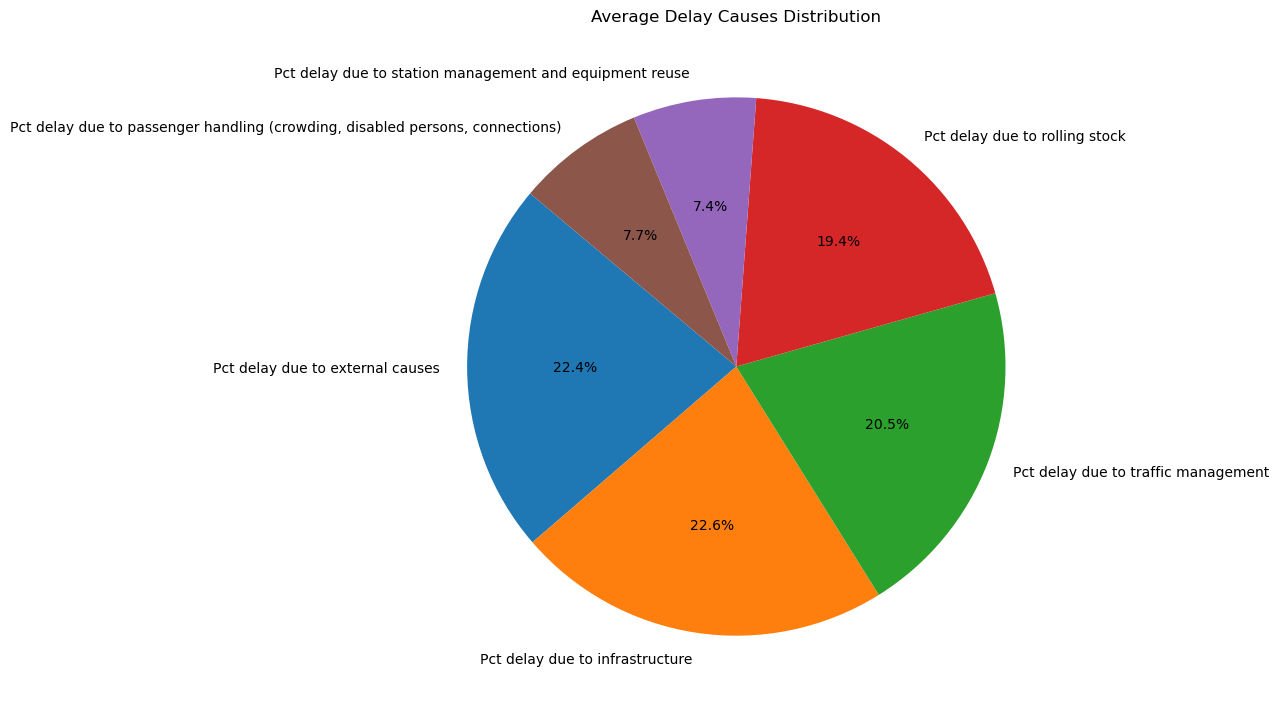

In [18]:
cause_cols = [
    "Pct delay due to external causes",
    "Pct delay due to infrastructure",
    "Pct delay due to traffic management",
    "Pct delay due to rolling stock",
    "Pct delay due to station management and equipment reuse",
    "Pct delay due to passenger handling (crowding, disabled persons, connections)",
]

mean_causes = df[cause_cols].mean()

plt.figure(figsize=(12, 12))
plt.pie(mean_causes, labels=mean_causes.index, autopct="%1.1f%%", startangle=140)
plt.title("Average Delay Causes Distribution")
plt.tight_layout()
plt.show()

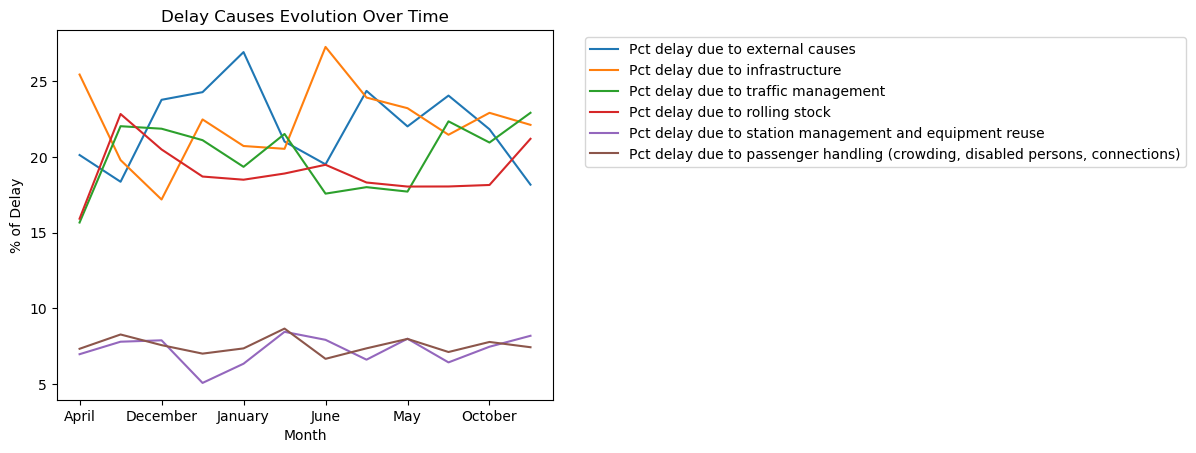

In [19]:
df = pd.read_csv("cleaned_dataset.csv")

if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df["Month"] = df["Date"].dt.strftime("%B")

df.groupby(df["Month"])[cause_cols].mean().plot()
plt.title("Delay Causes Evolution Over Time")
plt.xlabel("Month")
plt.ylabel("% of Delay")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

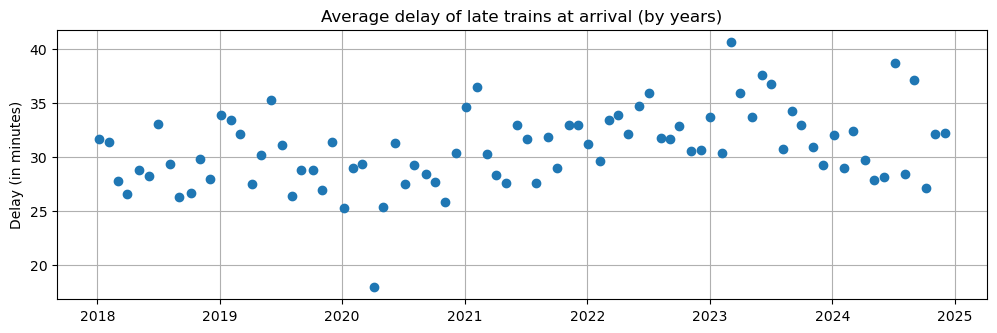

In [20]:
if "Date" in df.columns:
    df_time = df.set_index("Date")
    weekly_delay = (
        df_time["Average delay of late trains at arrival"].resample("W").mean()
    )
    plt.figure(figsize=(12, 3.5))
    plt.plot(weekly_delay.index, weekly_delay.values, marker="o", linestyle="-")
    plt.title("Average delay of late trains at arrival (by years)")
    plt.ylabel("Delay (in minutes)")
    plt.grid(True)
    plt.show()

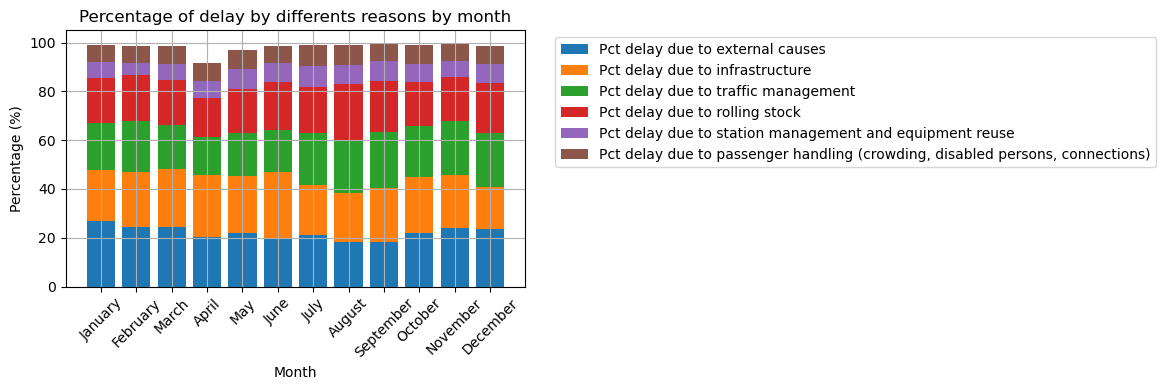

In [21]:
df = pd.read_csv("cleaned_dataset.csv")

if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df["Month"] = df["Date"].dt.strftime("%B")

# Get the columns we need for the graph that contains delay, groupby the columns and reorder the month so it is
# not in alphabetical order

cause_columns = [col for col in df.columns if col.startswith("Pct delay due to")]
grouped = df.groupby("Month")[cause_columns].mean()
month_order = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December",
]

# Group the index by month
grouped = grouped.reindex([m for m in month_order if m in grouped.index])

# Call matplotlib to render the graph
plt.figure(figsize=(12, 4))
bottom = None
for col in cause_columns:
    values = grouped[col]
    plt.bar(grouped.index, values, bottom=bottom, label=col)
    if bottom is None:
        bottom = values
    else:
        bottom += values

# Others informations that we need (title, x and y legend)
plt.title("Percentage of delay by differents reasons by month")
plt.ylabel("Percentage (%)")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.grid(True)
plt.show()

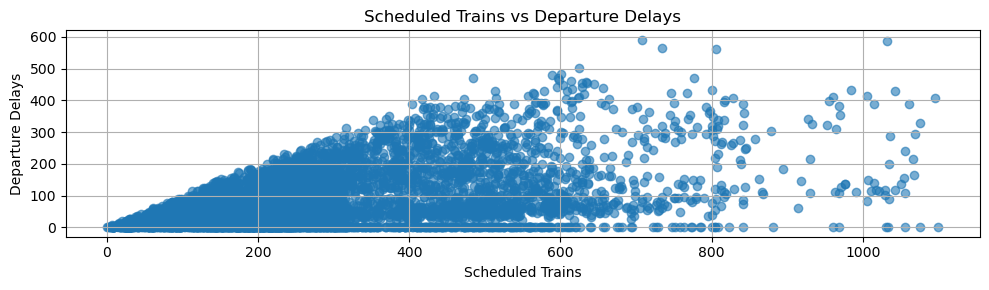

In [22]:
plt.figure(figsize=(10, 3))
plt.scatter(
    df["Number of scheduled trains"],
    df["Number of trains delayed at departure"],
    alpha=0.6,
)
plt.title("Scheduled Trains vs Departure Delays")
plt.xlabel("Scheduled Trains")
plt.ylabel("Departure Delays")
plt.grid(True)
plt.tight_layout()
plt.show()

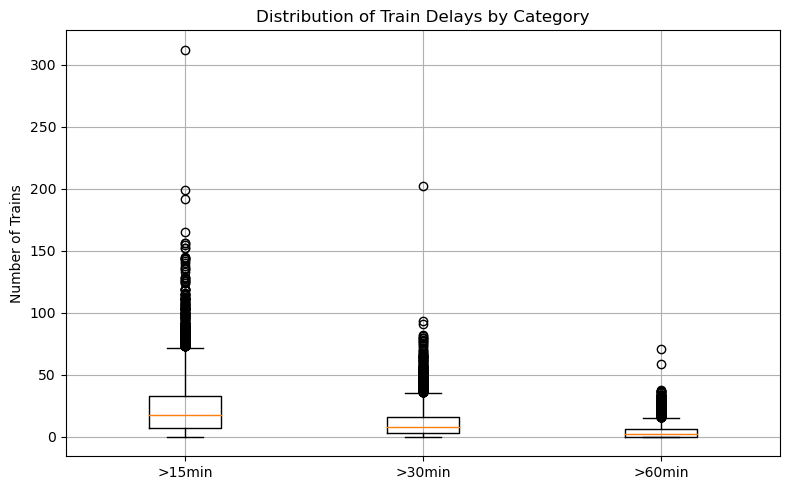

In [23]:
# get each values from >15, >30 and >60
data_to_plot = [
    df["Number of trains delayed > 15min"].dropna(),
    df["Number of trains delayed > 30min"].dropna(),
    df["Number of trains delayed > 60min"].dropna(),
]

# convert all this data to display a boxplot
plt.figure(figsize=(8, 5))
plt.boxplot(data_to_plot, labels=[">15min", ">30min", ">60min"])
plt.title("Distribution of Train Delays by Category")
plt.ylabel("Number of Trains")
plt.grid(True)
plt.tight_layout()
plt.show()

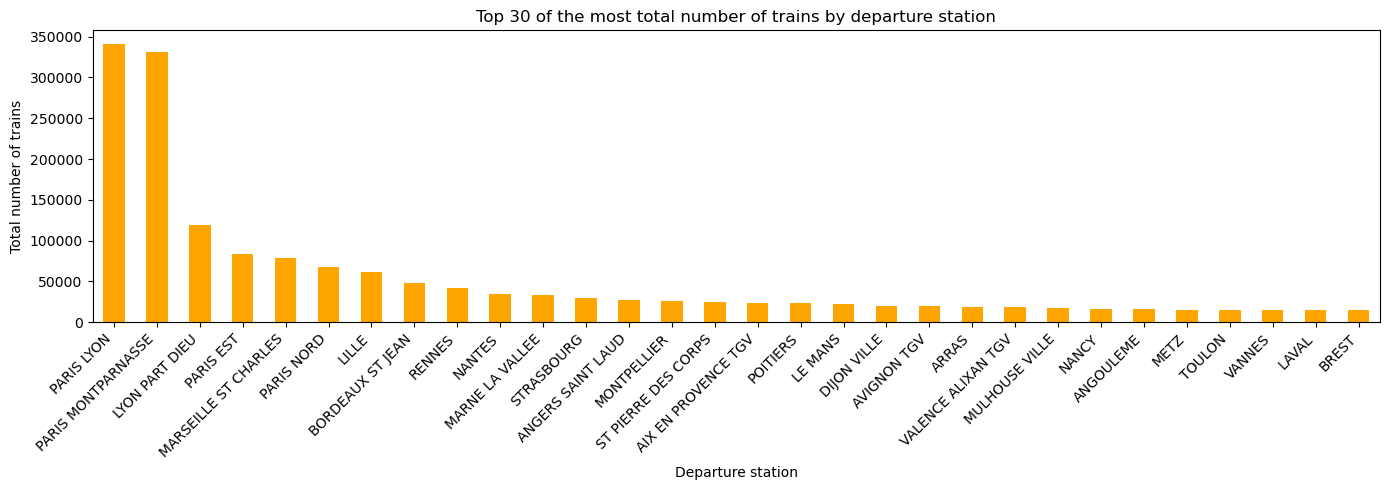

In [24]:
departure_trains = df.groupby("Departure station")["Number of scheduled trains"].sum()
plt.figure(figsize=(14, 5))
departure_trains.sort_values(ascending=False).head(30).plot(kind="bar", color="orange")
plt.title("Top 30 of the most total number of trains by departure station")
plt.xlabel("Departure station")
plt.ylabel("Total number of trains")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

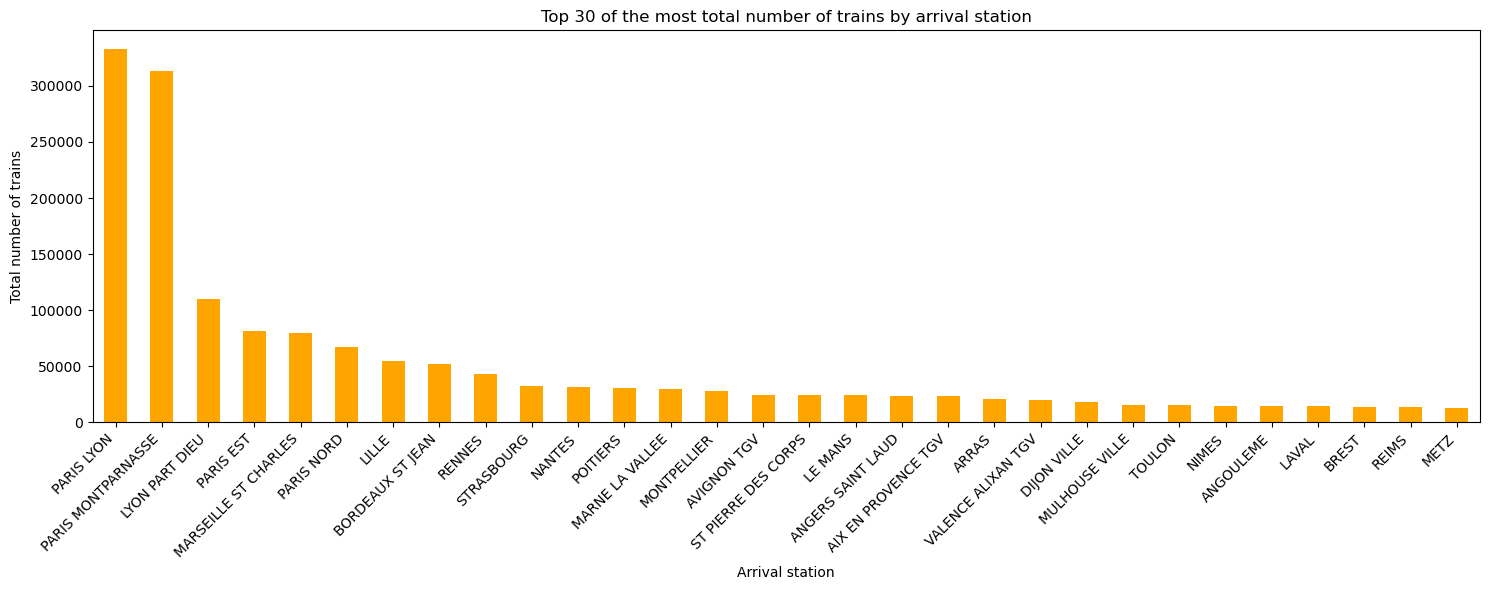

In [25]:
if "Arrival station" in df.columns:
    arrival_trains = df.groupby("Arrival station")["Number of scheduled trains"].sum()
    plt.figure(figsize=(15, 6))
    arrival_trains.sort_values(ascending=False).head(30).plot(
        kind="bar", color="orange"
    )
    plt.title("Top 30 of the most total number of trains by arrival station")
    plt.xlabel("Arrival station")
    plt.ylabel("Total number of trains")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

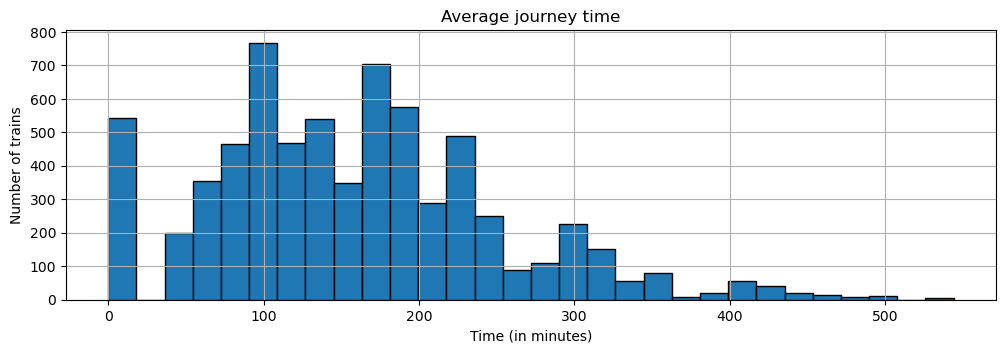

In [26]:
plt.figure(figsize=(12, 3.5))
plt.hist(df["Average journey time"].dropna(), bins=30, edgecolor="black")
plt.title("Average journey time")
plt.xlabel("Time (in minutes)")
plt.ylabel("Number of trains")
plt.grid(True)
plt.show()

### The following graphs display statistics for a connection between two stations. They include: average connection time, delays >15min, >30min and >60min, statistics on the origin of the delays and the average delay on arrival.

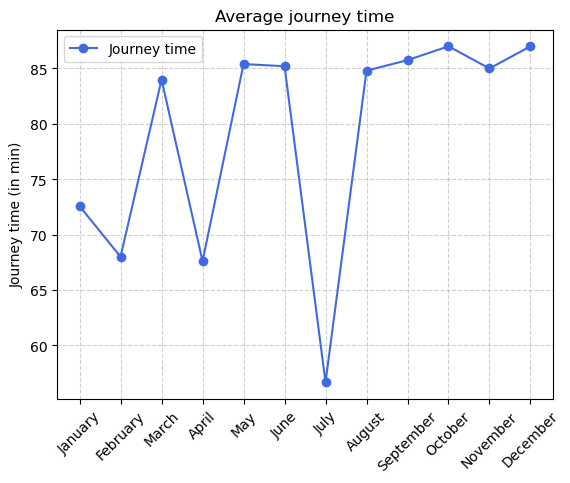

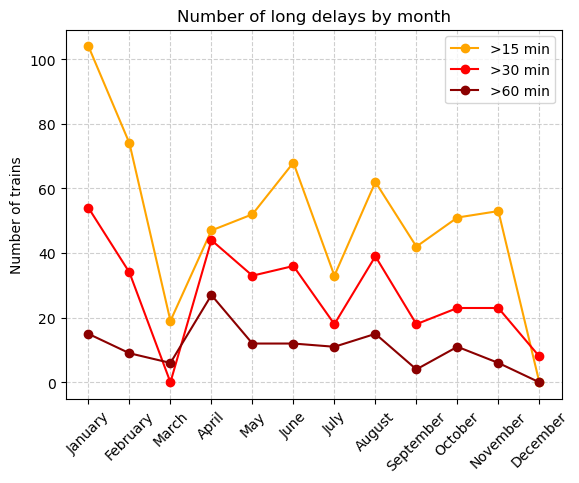

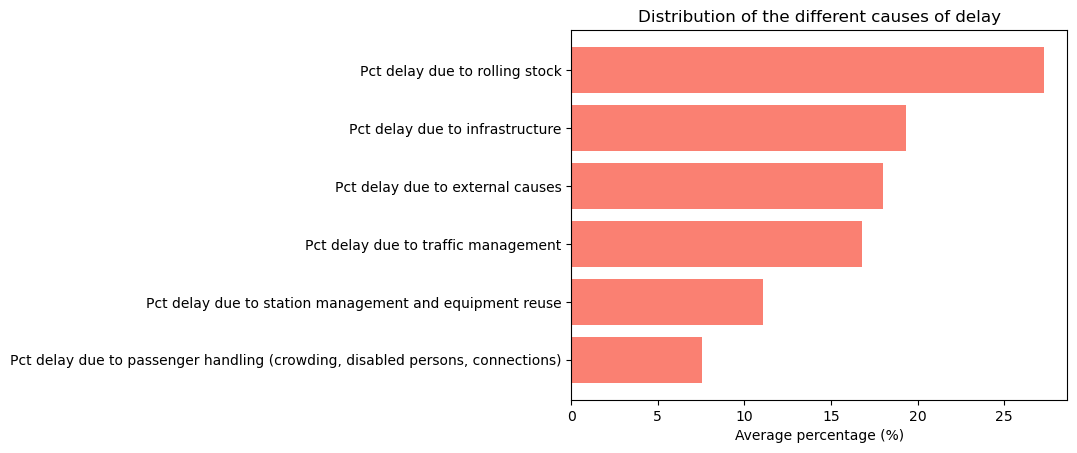

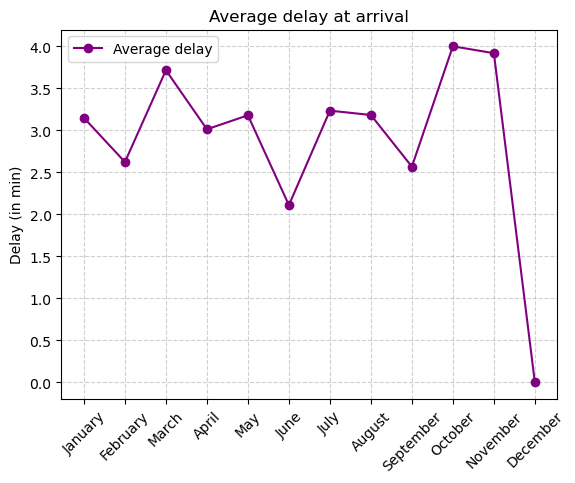

In [27]:
import pandas as pd
import matplotlib.pyplot as plt


def plot_line_dashboard(departure_station, arrival_station):
    line_df = df[
        (df["Departure station"] == departure_station)
        & (df["Arrival station"] == arrival_station)
    ]

    # reorder the month so its not in alphabetical order anymore
    month_order = [
        "January",
        "February",
        "March",
        "April",
        "May",
        "June",
        "July",
        "August",
        "September",
        "October",
        "November",
        "December",
    ]

    monthly_journey_time = (
        line_df.groupby("Month")["Average journey time"].mean().reindex(month_order)
    )
    monthly_delay_15 = (
        line_df.groupby("Month")["Number of trains delayed > 15min"]
        .sum()
        .reindex(month_order)
    )
    monthly_delay_30 = (
        line_df.groupby("Month")["Number of trains delayed > 30min"]
        .sum()
        .reindex(month_order)
    )
    monthly_delay_60 = (
        line_df.groupby("Month")["Number of trains delayed > 60min"]
        .sum()
        .reindex(month_order)
    )
    monthly_avg_arrival_delay = (
        line_df.groupby("Month")["Average delay of all trains at arrival"]
        .mean()
        .reindex(month_order)
    )

    # colons for the reason of delay
    causes_cols = [
        "Pct delay due to external causes",
        "Pct delay due to infrastructure",
        "Pct delay due to traffic management",
        "Pct delay due to rolling stock",
        "Pct delay due to station management and equipment reuse",
        "Pct delay due to passenger handling (crowding, disabled persons, connections)",
    ]
    mean_causes = line_df[causes_cols].mean().dropna().sort_values()

    # Graph °1: Average journey time
    plt.plot(
        monthly_journey_time.index,
        monthly_journey_time.values,
        label="Journey time",
        marker="o",
        color="royalblue",
    )
    plt.title("Average journey time")
    plt.ylabel("Journey time (in min)")
    plt.xticks(monthly_journey_time.index)
    plt.tick_params(axis="x", rotation=45)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

    # Graph °2: Number of long delays by  month
    plt.plot(
        monthly_delay_15.index,
        monthly_delay_15.values,
        label=">15 min",
        marker="o",
        color="orange",
    )
    plt.plot(
        monthly_delay_30.index,
        monthly_delay_30.values,
        label=">30 min",
        marker="o",
        color="red",
    )
    plt.plot(
        monthly_delay_60.index,
        monthly_delay_60.values,
        label=">60 min",
        marker="o",
        color="darkred",
    )
    plt.title("Number of long delays by month")
    plt.ylabel("Number of trains")
    plt.xticks(monthly_delay_15.index)
    plt.tick_params(axis="x", rotation=45)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

    # Graph °3: Distribution of the different causes of delay
    plt.barh(mean_causes.index, mean_causes.values, color="salmon")
    plt.title("Distribution of the different causes of delay")
    plt.xlabel("Average percentage (%)")
    plt.show()

    # Graph °4: Average delay at arrival
    plt.plot(
        monthly_avg_arrival_delay.index,
        monthly_avg_arrival_delay.values,
        label="Average delay",
        marker="o",
        color="purple",
    )
    plt.title("Average delay at arrival")
    plt.ylabel("Delay (in min)")
    plt.xticks(monthly_avg_arrival_delay.index)
    plt.tick_params(axis="x", rotation=45)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.show()


# call the function
plot_line_dashboard("PARIS EST", "METZ")